In [1]:
# Import statements
import numpy as np
import pandas as pd
import matplotlib
#matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

import csv
import pdb 

from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

In [3]:
# Read in data and transform it.

# Labels

with open('training_data.txt') as f:
    reader = csv.reader(f, delimiter=" ")
    labels = next(reader)
labels = labels[1:]

# Non-transformed

data_labeled = np.loadtxt('./training_data.txt', skiprows=1)
data_unlabeled = np.loadtxt('./test_data.txt', skiprows=1)
X = data_labeled[:, 1:]
Y = data_labeled[:, 0]

N, D = X.shape

# TF-IFD

data_all = np.append(X, data_unlabeled, axis=0)
tfidf_trans = TfidfTransformer()
data_all_tfidf = tfidf_trans.fit_transform(data_all).toarray()

X_tfifd = data_all_tfidf[0:N, :]

data_unlabeled_tfidf = data_all_tfidf[N:, :]


In [ ]:
# Cross validate SVM with linear kernel.


In [27]:
# Cross validate logistic regression with L2 reg, on TF-IFD data.
# Goal is an optimal choice of C.

nhypers = 50
Cs = np.linspace(0.92, 0.96, nhypers)
kfold = 5

models_logit = []
valscores_logit = []
for c in Cs:
    model = LogisticRegression(penalty='l2', C = c)
    scores = cross_val_score(model, X, Y, cv=kfold)
    valscores_logit.append(scores)
    models_logit.append(model)

KeyboardInterrupt: 

In [ ]:
valscores_logit = np.array(valscores_logit)
mean_valscores_logit = np.mean(valscores_logit, axis=1)
hyper_best_i_logit = np.argmax(mean_valscores_logit)
c_best_logit = Cs[hyper_best_i_logit]
print(hyper_best_i_logit, c_best_logit, mean_valscores_logit[hyper_best_i_logit])
plt.plot(Cs, mean_valscores_logit)

# kfold = 5: 1 0.935 0.844899929803

In [ ]:
logit_best_model = models_logit[hyper_best_i_logit]
logit_best_model.fit(X, Y)
L2weights = logit_best_model.coef_[0]

In [ ]:
# Cross validate multinomial Naive Bayes on unnormalized counts across percentiles of L2 logit weights.
# Goal is choosing columns.

abs_weights = np.absolute(L2weights)

nhypers = 40
Qs = np.linspace(60, 65, nhypers) # 0.1% of 1000 is 1

models_nbayes = []
valscores_nbayes = []
for Q in Qs: 
    cutoff = np.percentile(a=abs_weights, q=Q)
    whichweights = np.greater_equal(abs_weights, cutoff)
    X_reduced = X[:, whichweights] #.astype('bool')]
    model = MultinomialNB(alpha=1)
    scores = cross_val_score(model, X_reduced, Y, cv=kfold)
    valscores_nbayes.append(scores)
    models_nbayes.append(model)

6 53.0769230769 0.243266771052 0.849899730109


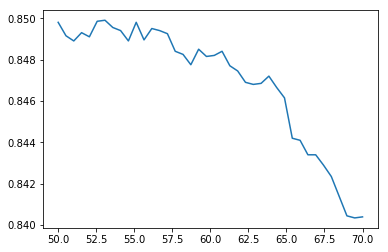

In [26]:
wQs = [np.percentile(abs_weights, q) for q in Qs]
valscores_nbayes = np.array(valscores_nbayes)
mean_valscores_nbayes = np.mean(valscores_nbayes, axis=1)
hyper_best_i_nbayes = np.argmax(mean_valscores_nbayes)
plt.plot(Qs, mean_valscores_nbayes)
print(hyper_best_i_nbayes, Qs[hyper_best_i_nbayes], wQs[hyper_best_i_nbayes], mean_valscores_nbayes[hyper_best_i_nbayes])

In [ ]:
NBprobs = models_nbayes[hyper_best_i_nbayes].fit()
feature_log_prob_